In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras import layers
import os

In [21]:
# 1) CARREGANDO A PLANILHA
df = pd.read_excel('C:/Users/Meu Computador/Documents/Tubaroes/SP_Reconstrucao_Siluriformes_2024_12_16.xlsx')

pasta_pesos = r'C:/Users/Meu Computador/Documents/Tubaroes/pesos_prop_Bagre_ind'
os.makedirs(pasta_pesos, exist_ok=True)

# 2) SELECIONANDO COLUNAS DE INTERESSE

df_bagre = df[['Ano',
               'Bagre_amarelo_ind',
               'Bagre_branco_ind',
               'Parare_ind',
               'Bagre_bandeira_ind',
               'Bagre_ind']]

# 3) DEFININDO OS ANOS QUE PRECISAMOS DESAGREGAR
#    Para o intervalo 1959 – 2022
anos_para_prever = np.arange(1959, 2023)

# 4) CORRIGINDO VALORES DE 'Bagre_aind' CASO EXISTA ALGUM ANO

for i in range(len(df_bagre)):
    # Se Bagre_indestiver vazio, mas as subespécies não:
    if (
        pd.isnull(df_bagre.loc[i,'Bagre_ind']) and
        not pd.isnull(df_bagre.loc[i,'Bagre_amarelo_ind']) and
        not pd.isnull(df_bagre.loc[i,'Bagre_branco_ind']) and
        not pd.isnull(df_bagre.loc[i,'Parare_ind']) and
        not pd.isnull(df_bagre.loc[i,'Bagre_bandeira_aind'])
    ):
        soma_sub = (df_bagre.loc[i,'Bagre_amarelo_ind'] +
                    df_bagre.loc[i,'Bagre_branco_ind'] +
                    df_bagre.loc[i,'Parare_ind'] +
                    df_bagre.loc[i,'Bagre_bandeira_ind'])
        df_bagre.loc[i,'Bagre_ind'] = soma_sub

# 5) FILTRANDO OS DADOS QUE TÊM REGISTROS VÁLIDOS (sem NaN) E REINDEXANDO
df_bagre = df_bagre.dropna(subset=[
    'Bagre_amarelo_indt',
    'Bagre_branco_ind',
    'Parare_ind',
    'Bagre_bandeira_ind',
    'Bagre_ind'
]).reset_index(drop=True)

# 6) CRIANDO UMA COLUNA COM A SOMA DAS SUBESPÉCIES
#    No código original, chamávamos de "Soma" (equivalente a Bagre_art).
df_bagre['Soma'] = (
    df_bagre['Bagre_amarelo_ind'] +
    df_bagre['Bagre_branco_ind'] +
    df_bagre['Parare_ind'] +
    df_bagre['Bagre_bandeira_ind']
)

# 7) SEPARANDO AS SUBESPÉCIES PARA FAZER A PROPORÇÃO
especies = ['Bagre_amarelo_ind',
            'Bagre_branco_ind',
            'Parare_ind',
            'Bagre_bandeira_ind']

# 8) CALCULANDO AS PROPORÇÕES DE CADA SUBESPÉCIE EM RELAÇÃO À SOMA
lista_de_prop = []
for esp in especies:
    dados = df_bagre[['Ano', esp, 'Soma']].copy()
    dados[f'Prop_{esp}'] = dados[esp] / dados['Soma']
    
    lista_de_prop.append(dados[f'Prop_{esp}'].values)
    
    print(f"\nEspécie: {esp}")
    print(dados.head())  # Exibe as 5 primeiras linhas

    anos_com_dados = df_bagre['Ano'].values
todos_anos = np.concatenate((anos_para_prever, anos_com_dados))
todos_anos.sort()


Espécie: Bagre_amarelo_art
    Ano  Bagre_amarelo_art      Soma  Prop_Bagre_amarelo_art
0  2010             1.6140  210.0904                0.007682
1  2011             2.7013  285.5480                0.009460
2  2012             4.4553  467.5131                0.009530
3  2013             5.6530  335.0208                0.016874
4  2014             4.9135  320.7329                0.015320

Espécie: Bagre_branco_art
    Ano  Bagre_branco_art      Soma  Prop_Bagre_branco_art
0  2010          199.1452  210.0904               0.947902
1  2011          269.2474  285.5480               0.942915
2  2012          435.2046  467.5131               0.930893
3  2013          312.2271  335.0208               0.931963
4  2014          296.2629  320.7329               0.923706

Espécie: Parare_art
    Ano  Parare_art      Soma  Prop_Parare_art
0  2010      0.3390  210.0904         0.001614
1  2011      0.8408  285.5480         0.002945
2  2012      1.2182  467.5131         0.002606
3  2013      1.0

In [22]:
# NORMALIZAÇÃO DOS ANOS
ano_mean = np.mean(anos_com_dados)
ano_std = np.std(anos_com_dados)

anos_para_prever_norm = (anos_para_prever - ano_mean) / ano_std
anos_com_dados_norm   = (anos_com_dados  - ano_mean) / ano_std

# 11) NORMALIZAÇÃO DAS PROPORÇÕES
lista_prop_norm = []
lista_prop_mean = []
lista_prop_std  = []

for prop in lista_de_prop:
    prop_mean = np.mean(prop)
    prop_std  = np.std(prop) if np.std(prop) != 0 else 1e-9
    
    prop_norm = (prop - prop_mean) / prop_std
    lista_prop_norm.append(prop_norm)
    lista_prop_mean.append(prop_mean)
    lista_prop_std.append(prop_std)

print(lista_prop_norm)

[array([-0.88630823, -0.83150157, -0.8293517 , -0.60293532, -0.650846  ,
       -0.79134149, -0.67697405, -0.35727978,  0.15818248,  1.6235039 ,
        2.18272252,  0.95260066,  0.70952858]), array([ 0.84140329,  0.74749057,  0.52113545,  0.54129123,  0.38581645,
        1.09641476,  0.99663931,  0.58823235, -0.23340714, -1.64041932,
       -2.00859067, -0.99888155, -0.83712474]), array([-1.16709288, -0.18263143, -0.43324456, -0.10088125,  2.43723898,
        1.43967494, -0.70948174, -0.993393  , -0.37139468, -0.35044958,
        0.8852668 ,  0.38815044, -0.84176204]), array([-0.65033215, -0.56524134, -0.00869859, -0.41005017, -0.12116024,
       -1.56265892, -1.35911544, -0.82909104,  0.351734  ,  1.58207026,
        1.57052178,  0.97937142,  1.02265043])]


In [23]:
def Fit_das_proporcoes(anos_norm,
                       lista_prop_norm,
                       lista_de_epocas,
                       lista_de_otimizadores,
                       lista_de_overwrite,
                       especies):
    
    # Mesmo modelo sequencial do código original
    model = keras.Sequential([
        layers.Dense(96, activation='leaky_relu', input_shape=(1,)),
        layers.Dense(32, activation='leaky_relu'),
        layers.Dense(80, activation='leaky_relu'),
        layers.Dense(80, activation='leaky_relu'),
        layers.Dense(96, activation='leaky_relu'),
        layers.Dense(112, activation='leaky_relu'),
        layers.Dense(1, activation='linear')
    ])
    
    lista_de_loss = []
    
    # Treinamento para cada subespécie
    for k, esp in enumerate(especies):
        opt = lista_de_otimizadores[k]
        model.compile(optimizer=opt, loss='mse')
        
        history = model.fit(
            anos_norm,
            lista_prop_norm[k],
            epochs=lista_de_epocas[k],
            verbose=0
        )
        lista_de_loss.append(history.history['loss'])
        
        # Salvando pesos em pasta correspondente
        model.save_weights(os.path.join(pasta_pesos, '.weights.h5'), overwrite=True)
    
    return model, lista_de_loss

In [24]:
Adam  = keras.optimizers.Nadam(learning_rate=0.001)
Nadam = keras.optimizers.Adam(learning_rate=0.001)

# Agora temos 4 subespécies, então definimos 4 valores:
lista_de_epocas      = [100, 100, 100, 100]
lista_de_otimizadores= [Nadam, Nadam, Nadam, Nadam]
lista_de_overwrite   = [True, True, True, True]

model, lista_de_loss = Fit_das_proporcoes(
    anos_com_dados_norm,
    lista_prop_norm,
    lista_de_epocas,
    lista_de_otimizadores,
    lista_de_overwrite,
    especies
)

In [25]:
lista_de_previsoes = []
lista_fits = []

p = np.linspace(-2, 2, 50)

for k, esp in enumerate(especies):
    model.load_weights('C:/Users/Meu Computador/Documents/Tubaroes/pesos_prop_Bagre_ind/.weights.h5')
    
    prev_ausentes = model.predict(anos_para_prever_norm)
    prev_ausentes = prev_ausentes * lista_prop_std[k] + lista_prop_mean[k]
    
    fit_valores = model.predict(p)
    fit_valores = fit_valores * lista_prop_std[k] + lista_prop_mean[k]
    
    # Ajustando valores para ficarem entre 0 e 1
    prev_ausentes[prev_ausentes < 0] = 0
    prev_ausentes[prev_ausentes > 1] = 1
    
    lista_de_previsoes.append(prev_ausentes)
    lista_fits.append(fit_valores)


2/2 [==============================] - 0s 2ms/step


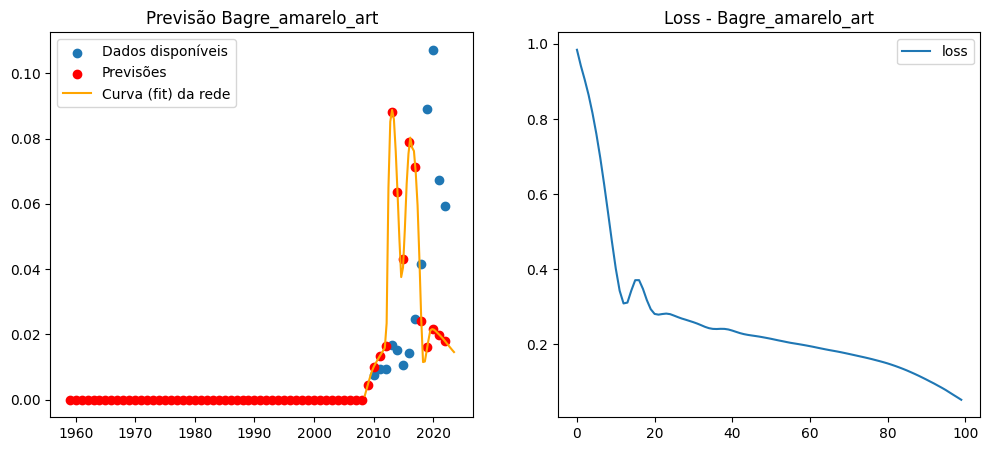

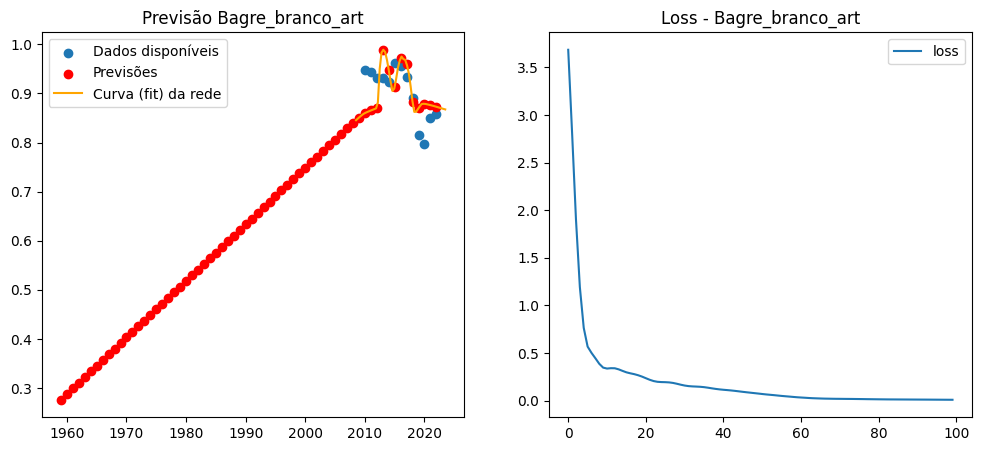

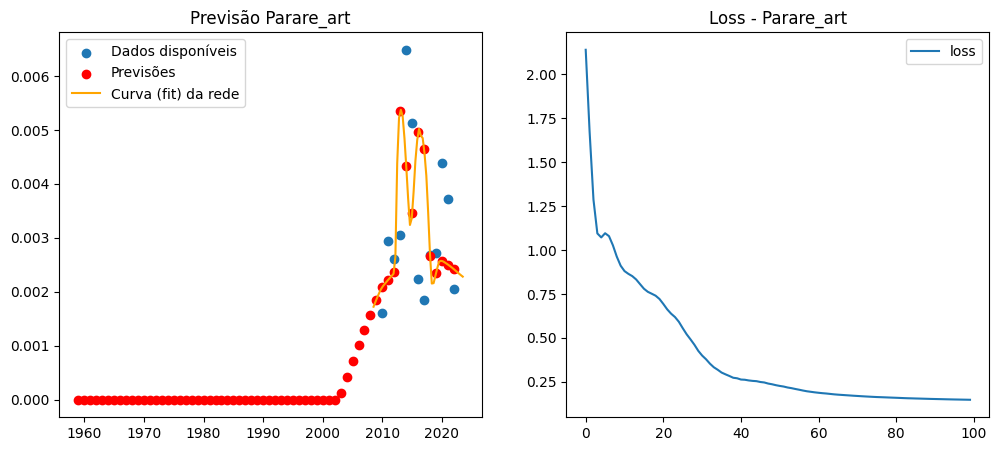

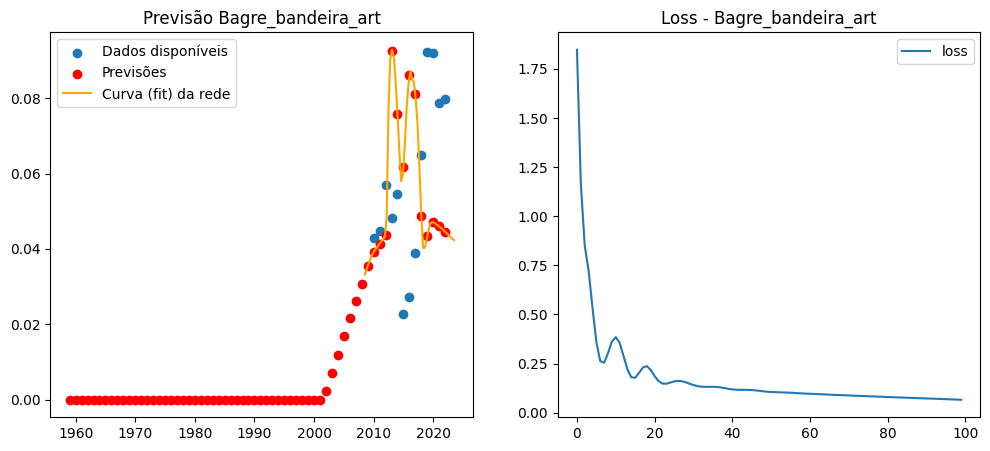

In [26]:
for k, esp in enumerate(especies):
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.scatter(anos_com_dados, lista_de_prop[k], label='Dados disponíveis')
    plt.scatter(anos_para_prever, lista_de_previsoes[k], color='red', label='Previsões')
    plt.plot(p*ano_std + ano_mean, lista_fits[k], color='orange', label='Curva (fit) da rede')
    plt.title(f'Previsão {esp}')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(lista_de_loss[k], label='loss')
    plt.title(f'Loss - {esp}')
    plt.legend()
    
    plt.show()

In [27]:
ano_inicial = min(anos_para_prever)
ano_final   = max(anos_para_prever)

anos = np.arange(ano_inicial, ano_final+1)
anos_norm = (anos - ano_mean)/ano_std

lista_prev_continua = []
for k, esp in enumerate(especies):
    model.load_weights('C:/Users/Meu Computador/Documents/Tubaroes/pesos_prop_Bagre_ind/.weights.h5')
    prev = model.predict(anos_norm)
    prev = prev * lista_prop_std[k] + lista_prop_mean[k]
    
    prev[prev < 0] = 0
    prev[prev > 1] = 1
    
    lista_prev_continua.append(prev.flatten())

2/2 [==============================] - 0s 1ms/step


In [30]:
prop_soma = np.zeros(len(anos))
for arr in lista_prev_continua:
    prop_soma += arr
prop_soma[prop_soma == 0] = 1e-9

for k in range(len(especies)):
    lista_prev_continua[k] /= prop_soma

In [32]:
df_prev = pd.DataFrame({
    'Ano': anos,
    especies[0]: lista_prev_continua[0],
    especies[1]: lista_prev_continua[1],
    especies[2]: lista_prev_continua[2],
    especies[3]: lista_prev_continua[3]
})

df_para_desagregar = df[['Ano','Bagre_ind']].copy()

df_final = df_para_desagregar.merge(df_prev, on='Ano', how='left')

# Multiplicamos cada proporção por 'Bagre_art' (agregado)
df_final['Bagre_amarelo_ind_prev']   = df_final['Bagre_ind'] * df_final['Bagre_amarelo_ind']
df_final['Bagre_branco_ind_prev']    = df_final['Bagre_ind'] * df_final['Bagre_branco_ind']
df_final['Parare_ind_prev']          = df_final['Bagre_ind'] * df_final['Parare_ind']
df_final['Bagre_bandeira_ind_prev']  = df_final['Bagre_ind'] * df_final['Bagre_bandeira_ind']

# 19) SALVAR EM EXCEL
df_final.to_excel(
    'C:/Users/Meu Computador/Documents/Tubaroes/Desagregacao_Bagre_ind_1959_2022.xlsx',
    index=False
)

print(df_final.head(15))

     Ano  Bagre_art  Bagre_amarelo_art  Bagre_branco_art  Parare_art  \
0   1950        NaN                NaN               NaN         NaN   
1   1951        NaN                NaN               NaN         NaN   
2   1952        NaN                NaN               NaN         NaN   
3   1953        NaN                NaN               NaN         NaN   
4   1954        NaN                NaN               NaN         NaN   
5   1955        NaN                NaN               NaN         NaN   
6   1956        NaN                NaN               NaN         NaN   
7   1957        NaN                NaN               NaN         NaN   
8   1958        NaN                NaN               NaN         NaN   
9   1959     112.00                0.0               1.0         0.0   
10  1960      65.00                0.0               1.0         0.0   
11  1961     102.93                0.0               1.0         0.0   
12  1962        NaN                0.0               1.0        